# Ensemble Methods - Part 2

## First Part - Necessary Code

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from auxiliary_functions import chart

In [2]:
# Import company colors
with open('plot_colors.json', 'r') as pc:
    color_dict = json.load(pc)

c_light, c_dark, c_blue, theme_flowchart = color_dict['color_light'], color_dict['color_dark'], color_dict['color_blue'], color_dict['theme_flowchart']

# Define color map for plotting
#color_map = ListedColormap([c_blue, c_light, c_dark])

In [3]:
# Generate Data for plots
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [4]:
# Train model with 3 estimators and learning rate 1
gbrt_3 = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt_3.fit(X, y)

# Train model with 200 estimators and learning rate 0.1
gbrt_200 = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_200.fit(X, y)


def plot_ensemble(X, y, models, figsize=(15,5)):
    
    axis_limit = [-.5, 0.5, -0.1, 0.8]
    
    x1 = np.linspace(axis_limit[0], axis_limit[1], 500)
    
    y_pred_3 = models[0].predict(x1.reshape(-1, 1))
    y_pred_200 = models[1].predict(x1.reshape(-1, 1))
    
    fig, ax = plt.subplots(1, 2, figsize=figsize, sharey=True)
    sns.set_context("talk", font_scale=0.8)
    
    ax[0].scatter(X, y, c=c_dark, s=20)
    ax[0].plot(x1, y_pred_3, c=c_light, linewidth=2.5, label="Ensemble predictions")
    ax[0].set(xlabel='X', ylabel='y', title='learning_rate=1.0, n_estimators=3')
    ax[0].axis(axis_limit)
    
    ax[1].scatter(X, y, c=c_dark,  s=20)
    ax[1].plot(x1, y_pred_200, c=c_light, linewidth=2.5, label="Ensemble predictions")
    ax[1].set(xlabel='X', title='learning_rate=0.1, n_estimators=200')
    ax[0].axis(axis_limit)
    
    ax[0].legend()
    ax[1].legend()

In [5]:
# Train test split
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

min_error = np.min(errors)


def plot_early_stopping(X, y, model, figsize=(15,5)):
    
    axis_limit = [-.5, 0.5, -0.1, 0.8]
    
    x1 = np.linspace(axis_limit[0], axis_limit[1], 500)
    
    y_pred_best = model.predict(x1.reshape(-1, 1))
    
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    sns.set_context("talk", font_scale=0.8)
    
    ax[0].plot(errors, c=c_blue, marker='o', markersize=5)
    ax[0].plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
    ax[0].plot([0, 120], [min_error, min_error], "k--")
    ax[0].text(gbrt_best.n_estimators_, min_error*1.2, "Minimum", ha="center")
    ax[0].set(xlabel='Number of trees', ylabel='Error', title='Validation Error')
    ax[0].axis([0, 120, 0, 0.01])
    
    ax[1].scatter(X, y, c=c_dark,  s=20)
    ax[1].plot(x1, y_pred_best, c=c_light, linewidth=2.5)
    ax[1].set(xlabel='X', ylabel="y", title=f"Best model ({gbrt_best.n_estimators_} trees)")
    ax[1].axis(axis_limit)

## Second Part - Lecture

<div class="slide-title">

# Ensemble Methods - Part 2
    
</div>    

## Agenda

1. Recap CARTs
2. How and why do Ensembles work
3. Different models
4. Stacking
4. Bagging (Random Forests, Extra Trees)
5. Boosting
7. Interpretability


## Recap CART - Classification and regression trees

<div class="slide-chapter-split">
    <div class="title-chapter">Recap CART - Classification and regression trees</div>
    <div class="image-container">
        <img src="../images/ensemble_methods/img_p2_1.png">
    </div>
</div>

### CART 

Pseudocode:
```
fitTree (node, D, depth):
    node.prediction = mean or class label
    DL, DR <- split(D)
    if not worth_splitting(depth, cost, DL, DR):
        return node
    else:
        node.left  <- fitTree(node, DL, depth+1)
        node.right <- fitTree(node, DR, depth+1)
        return node
```

### CART (Classification and Regression Tree)

<div class="group">
    <div class="text_70">

**General:**

* Finding the optimal split of the data is NP-complete.
* CART uses a greedy procedure to compute a **locally minimal MLE** (Maximum likelihood estimation).
* The split function chooses **best feature and best value to split on**.

**Cost functions:**

* Regression $\rightarrow J(b)=\frac{1}{n}\sum_{i=1}^{n}{(y_{i}-\hat{y_{i}})^2}$ (MSE)
* Classification $\rightarrow I_{G}(p)= 1-\sum_{i=1}^{J}\,p_{i}^{2}$ (Gini impurity)
    </div>
    <br><br><br>
    <div class="images_30">
        <img src="../images/decision_tree/img_p13_1.png">
    </div>
</div> 

<div class="alert alert-block alert-info">
<b>Note:</b> 
NP-complete (nondeterministic polynomial-time complete) defines a problem which is easy to understand, easy to verify but difficult to solve e.g. a jigsaw puzzle.
</div>

Notes: cost function for regression: J means cost
        cost function for classification: J means number of classes, I(G) is the gini index

### CART 

<div class="group">
    <div class="text_70">

**Regularisation:**

* pruning to avoid overfitting
* Grow a full tree and then prune e.g.
    - `max_leaves`
    - `max_depth`
    - `min_sample_size`
    </div>
    <br><br><br>
    <div class="images_30">
        <img src="../images/decision_tree/img_p13_1.png">
    </div>
</div> 


### CART - pros and cons

<br>

<table class="confusion_matrix" border="1" width="1800">
  <thead>
    <tr>
      <th><b>&nbsp;&nbsp;PROS&nbsp;&nbsp;</b></th>
      <th><b>&nbsp;&nbsp;CONS&nbsp;&nbsp;</b></th>
    </tr>
  </thead>
</table>

### CART - pros and cons

<br>

<table class="confusion_matrix" border="1" width="1800">
  <thead>
    <tr>
      <th><b>PROS</b></th>
      <th><b>CONS</b></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td class="smaller-font-size">white box model - easy to interpret</td>
      <td class="smaller-font-size">not very accurate ...</td>
    </tr>
    <tr>
      <td class="smaller-font-size">can handle mixed data, discrete and continuous</td>
      <td class="smaller-font-size">greedy nature of constructing</td>
    </tr>
    <tr>
      <td class="smaller-font-size">insensitive to transformations of data... split points based on ranking  </td>
      <td class="smaller-font-size">trees are unstable, small changes to the input can lead to large changes in tree structure</td>
    </tr>
    <tr>
      <td class="smaller-font-size">relative robust to outliers</td>
      <td class="smaller-font-size">tend to overfit (aka high variance estimators)</td>
    </tr>
  </tbody>
</table>

### Trees being unstable

**Q:** Should you trust and follow a single CART?

<div class="group">
    <div class="text_70">       
        
* Changes in your trees can lead to different structure and maybe different decisions
* As in investment, it is not advisable to lay all eggs in one basket
    </div>
    
    <div class="images_30">   
        <img src="../images/ensemble_methods/img_p7_1.png">
    </div>
</div>

### Trees being greedy and overfitting

<div class="group">
    <div class="text_70">

How to find out what to order at the restaurant?
* **Try everything!** <br>... and then order what you liked best.
* **Ask your friends to try something**, <br>find out which they preferred more and try those maybe?

**Q:** Which do you find more feasible?
    </div>
    <br><br><br>
    <div class="images_30">
        <img src="../images/ensemble_methods/eating_cloud.png">
    </div>
</div> 


<center>
    <img src="../images/ensemble_methods/img_p9_1.png" position="center" size="cover">
</center>

Notes: Who wants to be a millionaire allows contestants to get help from a friend and help from the audience. Over the run of the show, which help type do you think performed better? by how much? The majority of the audience picked the right answer 91 percent of the time, while individual friends only did so 65 percent of the time. This is an example of “crowd wisdom”, it’s an idea, summarized in the 2004 book by James Surowiecki by the same name, which states that the aggregate information in a group often leads to a better decision than any single member of the group. Image licence: unknown

<center>
    <img src="../images/ensemble_methods/img_p10_1.png" position="center" width=800>
</center>


Notes: What about Wikipedia? I think we can all agree it is a fantastic CROWD SOURCED project for freedom of information, accessibility and relevance. But is it also “crowd wisdom”? Does it create a more reliable knowledge base than sources that aren’t crowd sourced, such as encyclopedias, text books and news sources. If you are interested, you can read a very LONG and very interesting wikipedia article about its own reliability (if you don’t mind the paradox). for crowd wisdom we need the following conditions: image licence: free to use https://commons.wikimedia.org/wiki/File:WikipediaLogo-TheOfficiaFour.jpg

## Wisdom of Crowds Theory

* Diversity of opinions
* Independence of opinions
* Decentralisation
* Aggregation

Notes: Let’s see what are the requirements or assumptions of the Crowd Wisdom theory: 1. Each person has private information. 2. People aren’t influenced by those around them. 3. People are specialised and can draw on local knowledge. 4. Some mechanism exists to turn private judgements into a collective decision. Do you think they hold for both WWtBaM and Wikipedia? <CLICK>

### Who Wants to Be a Millionaire 💸  //  📖 Wikipedia

<br>

<table class="confusion_matrix" >
  <thead>
    <tr>
      <th><b>Who Wants to Be a Millionaire 💸</b></th>
      <th><b>Wikipedia 📖</b></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td colspan=2 class="cell-class">Each person has private information.</td>
    </tr>
    <tr>
      <td class="smaller-font-size">The audience members should have opinions of their own.</td>
      <td class="smaller-font-size">Wikipedians have opinions of their own.</td>
    </tr>
    <tr>
      <td colspan=2 class="cell-class">Independence of opinions.</td>
    </tr>
    <tr>
      <td class="smaller-font-size">There might be some small local effects.</td>
      <td class="smaller-font-size">Wikipedians often don’t know each other.</td>
    </tr>
    <tr>
      <td colspan=2 class="cell-class">Decentralisation</td>
    </tr>
    <tr>
      <td class="smaller-font-size">Trivia knowledge isn’t specialised. People can make educated guesses.</td>
      <td class="smaller-font-size">Wikipedia is decentralized by definition. Single-author pages require review.</td>
    </tr>
    <tr>
      <td colspan=2 class="cell-class">Aggregation</td>
    </tr>
    <tr>
      <td class="smaller-font-size">People chose the most popular vote: max()</td>
      <td class="smaller-font-size">Talk pages to discuss and mediate disagreements. Decisions by consensus or executive decision. Loss of independence or lack of aggregation.</td>
    </tr>
  </tbody>
</table>

Notes: For Wikipedia, probably there are some edge cases where there aren’t enough editors for highly specialised knowledge. But from my experience in academia, there isn’t a topic you can’t find two opposing opinions on ;) in WWtBaM (I’m not sure how much time the audience gets to decide. They might speak to their friend or neighbour). Is it true for Wiki, certainly in some cases the editors don’t know each other. Maybe in highly specialised articles there isn’t independance. People are specialised and can draw on local knowledge. This certainly seems true for both. Trivia knowledge isn’t so specialised by definition, so at least some audience members could make educated guesses, if they don’t know the precise answer.Wikipedia, is decentralised by definition to my best understanding. Pages that are single authored are often marked as requiring review. Some mechanism exists to turn private judgements into a collective decision. As we already saw, WWtBaM counts the number of votes per possible answer.But Wikipedia doesn’t aggregate information. When there is diversity of opinions, as required by the first assumption, the editors use the talk pages to discuss, mediate and come to an agreement. This is a way to reach consensus, but it’s not aggregation.

### fold.it

<center>
    <img src="../images/ensemble_methods/img_p13_1.png" width=1000>
</center>

Notes: Does anyone know what this is? … <CLICK> Fold.It is a video-game where the players puzzle solving skills are used to discover structures of complex protein folds. These structures can be crucial for designing treatments to diseases such as HIV and Cancer. Finding the pattern of a protein is a very difficult computational problem, since computers are not great at solving spatial puzzles. But people are actually really good at spatial thinking. The virtual molecules follow the same chemical rules that are obeyed by real molecules. When someone playing the game comes up with a more elegant structure that reflects a lower energy state for the molecule, his or her score goes up. If the structure requires more energy to maintain, or if it doesn't reflect real-life chemistry, then the score is lower. In this case the aggregation function we’re using is simply the minimum of all the players’ solutions. The Fold.it players have already solved a molecular puzzle that stumped scientists for years. They identified the structure of a virus that’s vital for AIDS research. and they did it in only 10 days. Image licence: Public Domain https://de.wikipedia.org/wiki/Datei:Foldit_screenshot_2.jpg

### Reducing variance by aggregation

<center>
    <img src="../images/ensemble_methods/img_p14_1.png" position="center">
</center>

Notes: I hope you’re starting to find the Wisdom of Crowds as interesting as I do. This is also <CLICK> the underlying theory of reducing the variance by aggregation, which you might also known as the philosophical idea behind a ML algorithm called Random Forest. In which we partition the data to small subsets, make an estimation based on each small subset, and then aggregate the result to get a better estimation.

## Ensemble learning... asking for more opinions and making a judgment call


<div class="group">
    <div class="text_70">

A collection of models working together on same dataset

**Mechanism:**
* majority voting

**There are different ways to do it:**
* **<span class="color-brand">bagging</span>** (same model on different parts of the data)
* **<span class="color-brand">boosting</span>** (seq. adjusts for importance of observations)
* **<span class="color-brand">stacking / blending</span>** (training in parallel and combining)

**Advantages:**
* less sensitive to overfitting
* better model performance
    </div>
    <br><br><br>
    <div class="images_30">
        <img src="../images/ensemble_methods/more_opinions.png">
    </div>
</div> 



## Majority Voting - how it works

For **each observation** you have **different predictions** from **different models**

You need one prediction... so you aggregate

Aggregating the different models can be done in many ways e.g. averages, mode, median




In [6]:
chart("""
flowchart TD
    A(Training Set) --> B(Model 1 
    fa:fa-cogs) --New Instance--> F(( 1 )) --> J{Voting} --> K((1))
    A --> C(Model 2
    fa:fa-cogs) --New Instance--> G(( 0 )) --> J
    A --> D(Model 3 
    fa:fa-cogs) --New Instance--> H(( 1 )) --> J
    A --> E(Model 4
    fa:fa-cogs) --New Instance--> I(( 1 )) --> J
    subgraph "Ensemble"
        B
        C
        D
        E
    end
""")

<div class="alert alert-block alert-info">
<b>Note:</b> 
    
Methods based on the values of the probabilities need to return calibrated probabilities.

</div>

### Majority Voting - how it works

For each observation you have different predictions. How do you aggregate this to get one value?

**<center>Hard Voting &nbsp;  &nbsp;  &nbsp;  &nbsp; &nbsp;  &nbsp;  &nbsp;  &nbsp;  &nbsp;  &nbsp;</center>**
<center>takes the majority class  &nbsp;  &nbsp;  &nbsp;  &nbsp; &nbsp;  &nbsp;  &nbsp;  &nbsp;  &nbsp;  &nbsp;</center>

**<center>Soft Voting &nbsp;  &nbsp;  &nbsp;  &nbsp; &nbsp;  &nbsp;  &nbsp;  &nbsp;  &nbsp;  &nbsp;</center>**
<center>average of summed probability vectors &nbsp;  &nbsp;  &nbsp;  &nbsp; &nbsp;  &nbsp;  &nbsp;  &nbsp;  &nbsp;  &nbsp;</center>

In [7]:
chart("""
flowchart TD
    A(Training Set) --> B(Model 1 
    fa:fa-cogs) --New Instance--> F(( 0 )) --> J{mode
    0} --> K((0))
    A --> C(Model 2
    fa:fa-cogs) --New Instance--> G(( 1 )) --> J
    A --> D(Model 3 
    fa:fa-cogs) --New Instance--> H(( 0 )) --> J
    A --> E(Model 4
    fa:fa-cogs) --New Instance--> I(( 0 )) --> J
    subgraph "Ensemble"
        B
        C
        D
        E
    end
""")

In [8]:
chart("""
flowchart TD
    A(Training Set) --> B(Model 1 
    fa:fa-cogs) --New Instance--> F(( 0.41 )) --> J{mean
    0.56} --> K((1))
    A --> C(Model 2
    fa:fa-cogs) --New Instance--> G(( 0.99 )) --> J
    A --> D(Model 3 
    fa:fa-cogs) --New Instance--> H(( 0.35 )) --> J
    A --> E(Model 4
    fa:fa-cogs) --New Instance--> I(( 0.48 )) --> J
    subgraph "Ensemble"
        B
        C
        D
        E
    end
""")

<div class="alert alert-block alert-info">
<b>Note:</b> 
    
Soft voting tends to outperform hard voting.

</div>

### Majority Voting - why it works



<div class="group">
    <div class="text_70">

**Intuition:** at observation level not all classifiers will be wrong in the same way at the same time

**Prerequisites** for this to work:
* models need to be better than random, i.e. **weak learners**
* you want the models to be different and that get translated in statistics to non-correlated or **sufficiently independent** or .. diverse
* you need a **sufficient amount** of weak learners 
    </div>
    <br><br><br>
    <div class="images_30">
        <img src="../images/ensemble_methods/multible_learners.png">
    </div>
</div> 


<div class="alert alert-block alert-info">
<b>Note:</b> 
    
A weak learner model has an average true positive rate slightly better than 50% and an average false positive rate slightly less than 50%.

</div>

### Majority Voting - why it works


<div class="group">
    <div class="text_70">

**What does it mean that the models are independent/ different?**

If two weak learners would be correlated then a observation is likely to have same prediction by both weak learners.

**Why do you think it is important?**

Probability of an observation x to be misclassified by the ensemble learner is basically equivalent to it being misclassified by a majority of the weak learners.
    </div>
    <br>
    <div class="images_30">
        <img src="../images/ensemble_methods/weak_learners.png">
        **<span class="color-brand">A weak learner is 51% right and 49% wrong</span>**
    </div>
</div> 

<div class="alert alert-block alert-info">
<b>Note:</b> 
    
This can be proven by math. Feel free :D to try.. or <br>
run 1000 coin toss experiments and aggregate.

</div>

### Majority Voting - why it works

$X_i$ are independent identically distributed:

$\text{Var} (X_{i})=\sigma^{2}$

$\text{Var} (\bar{X})=\text{Var}\left(\frac{1}{n}\sum_{i=1}^{n}X_i\right) = \frac{\sigma^2}{n}$, according to the central limit theorem.



Drop the independence assumption $X_i$ are correlated by $\rho$:

$ \text{Var}(\bar{X})=\rho\sigma^{2}+(1-\rho)\frac{\sigma^{2}}{n}$

### Example of weak learners

<div class="group">
    <div class="text">

$$m=1000, \ p=0.51$$
        
$$p(x<k) = cdf(k=500) = 27.4\%$$

        
Chances to be wrong with m = 1000 weak learners.
    </div>
    <div class="images">
        Cumulative distribution function (cdf)
        <img src="../images/ensemble_methods/img_p21_1.png" width=400>
    </div>
</div> 

Notes: The question “answered” here is: If we have an unfair coin, that is a coin that shows HEADS 51% (p=.51) and TAILS only 49% of the time. Experiment: Let's flip the coin 1000 times (n=1000) and count how often we got HEADS (K) We would expect for each run of the experiment to get 510 HEADS (=expected value =n*p ) and 490 TAILS (sometimes a little more, sometimes a little less) Now, let's conduct the experiment a million times and remember how often we got heads(K). If we make a histogram for K (~p(x=k)), we would expect to see a bell-curve. Most of the time we get 510, almost as often 509 or 511, almost as often 508 or 512… with decreasing occurrences left and right of the expected 510. If we take the histogram start from the left and successively add the values we encounter, we get to the cpf, i.e. the cumulative probability function which shows us the probability of getting “less than k” observations. (Shown on this slide) In our example, the chance of getting less than 1001 Heads is? p=1. We cannot get more than 1000 Heads in 1000 throws. the chance of getting less than 540 heads is (according to the plot) ~98% (-> or if you look at it from the other way: the chances of getting more than 540 heads in our 1000 throws is already only about 2%) the chance of getting less than 510 heads is (according to the plot) =50% (because this is exactly the expected value!) To bring it back to the learners: Each Weak learner is basically a coin flip with a slightly unfair coin: if each of the 1000 weak learners has an accuracy of 51% (and they are all completely independent from each other). Making a prediction now corresponds to the experiment from above: we “flip” each weak learner and the result. We would expect (given the accuracy) to get for each experiment run (about) 510 right and 490 wrong answers. But – it could also be 505 (right)vs 495(wrong)… or 496(right) vs 504(wrong). If we apply majority voting, the first two (510 / 505 right) would make us take the correct prediction, whereas the last one (496 right) would make us take the wrong prediction. The magic point here is: how often are less than 500 of our models correct (or in a formula p(x<k=500)). From the shown graph we can see that this is 27,4%. SO If we select the majority answer from 1000 weak learners with an accuracy of just 51% -> we get an ensemble accuracy of 72,6% (= 100-27.4)! If we do the same thing, but we make our learners slightly better, i.e. they have an accuracy of 55% percent vs 51%, we get the cdf from the next slide. Then the chance of less than 500 of our models being correct (or in a formula p(x<k=500) is down to 0,08% -> so we get an ensemble accuracy of 99,92%

### Example of weak learners

<div class="group">
    <div class="text">

$$m=1000, \ p=0.55$$

$$p(x<k) = cdf(k=500) = 0.08\% $$
        
Chances to be wrong with m = 1000 weak learners.
    </div>
    <div class="images">
        Cumulative distribution function (cdf)
        <img src="../images/ensemble_methods/img_p22_1.png" width=400>
    </div>
</div> 

Notes: The question “answered” here is: If we have an unfair coin, that is a coin that shows HEADS 51% (p=.51) and TAILS only 49% of the time. Experiment: Let's flip the coin 1000 times (n=1000) and count how often we got HEADS (K) We would expect for each run of the experiment to get 510 HEADS (=expected value =n*p ) and 490 TAILS (sometimes a little more, sometimes a little less) Now, let's conduct the experiment a million times and remember how often we got heads(K). If we make a histogram for K (~p(x=k)), we would expect to see a bell-curve. Most of the time we get 510, almost as often 509 or 511, almost as often 508 or 512… with decreasing occurrences left and right of the expected 510. If we take the histogram start from the left and successively add the values we encounter, we get to the cpf, i.e. the cumulative probability function which shows us the probability of getting “less than k” observations. (Shown on this slide) In our example, the chance of getting less than 1001 Heads is? p=1. We cannot get more than 1000 Heads in 1000 throws. the chance of getting less than 540 heads is (according to the plot) ~98% (-> or if you look at it from the other way: the chances of getting more than 540 heads in our 1000 throws is already only about 2%) the chance of getting less than 510 heads is (according to the plot) =50% (because this is exactly the expected value!) To bring it back to the learners: Each Weak learner is basically a coin flip with a slightly unfair coin: if each of the 1000 weak learners has an accuracy of 51% (and they are all completely independent from each other). Making a prediction now corresponds to the experiment from above: we “flip” each weak learner and the result. We would expect (given the accuracy) to get for each experiment run (about) 510 right and 490 wrong answers. But – it could also be 505 (right)vs 495(wrong)… or 496(right) vs 504(wrong). If we apply majority voting, the first two (510 / 505 right) would make us take the correct prediction, whereas the last one (496 right) would make us take the wrong prediction. The magic point here is: how often are less than 500 of our models correct (or in a formula p(x<k=500)). From the shown graph we can see that this is 27,4%. SO If we select the majority answer from 1000 weak learners with an accuracy of just 51% -> we get an ensemble accuracy of 72,6% (= 100-27.4)! If we do the same thing, but we make our learners slightly better, i.e. they have an accuracy of 55% percent vs 51%, we get the cdf from the next slide. Then the chance of less than 500 of our models being correct (or in a formula p(x<k=500) is down to 0,08% -> so we get an ensemble accuracy of 99,92%

## How does my model look as an ensemble model?

<div class="slide-chapter">

## How does my model look as an ensemble model?
    
</div>

### Adaptive basis function models

$$ f(x)=b_{0}~\ + \sum b_{m}\phi_{m}(x)$$

This framework covers many models: decision trees, neural networks, random forest, boosting trees and so on... basically we have m parametric basis functions.

**How does the formula look like for a decision tree?**

Notes: Basis functions (called derived features in machine learning) are building blocks for creating more complex functions. In other words, they are a set of k standard functions, combined to estimate another function—one which is difficult or impossible to model exactly. For example, individuals powers of x— the basis functions 1, x, x2, x3…— can be strung together to form a polynomial function. The set of basis functions used to create the more complex function is called a basis set. Fitting the data with basis functions is possible, but requires choosing appropriate parameters, instead we could use Adaptive basis functions that learn the parameters by themselves. We gain performance of the model, but loose interpretability. https://www.oranlooney.com/post/adaptive-basis-functions/

<div class="slide-chapter-split">
    <div class="title-chapter">BREAK</div>
    <div class="image-container">
        <img src="../images/general/break.png">
    </div>
</div>

## How do I produce different models with the same data?


<div class="slide-chapter">

## How do I produce different models with the same data?

</div>


## I. Bagging

<div class="slide-chapter">

## I. Bagging

</div>

### Bagging

<div class="group">
    <div class="text">

<span class="color-brand" style="font-weight:bold;">B</span>ootsprap <span class="color-brand" style="font-weight:bold;">agg</span>regat<span class="color-brand" style="font-weight:bold;">ing</span>

$$ f(x)= \frac{1}{m}\sum f_{m}(x)$$  
        
Training $m$ **different trees** on **different subsets** of data chosen randomly with replacement.
    </div>
    <div class="images">
        <img src="../images/ensemble_methods/img_p28_3.png">
    </div>
</div> 

<div class="alert alert-block alert-info">
<b>Note:</b> 
    
Running same learning algorithms on different subsets can result in still highly correlated predictors.

</div>

### Bagging

<span class="color-brand" style="font-weight:bold;">B</span>ootsprap <span class="color-brand" style="font-weight:bold;">agg</span>regat<span class="color-brand" style="font-weight:bold;">ing</span>

$$ f(x)= \frac{1}{m}\sum f_{m}(x)$$  
        
Training $m$ **different trees** on **different subsets** of data chosen randomly with replacement.

In [9]:
chart("""
flowchart TD
    A(Training Data
    observation 1
    observation 2
    observation 3
    observation 4
    observation 5
    ) --> B(Bootstrapped Data 1
    observation 1
    observation 2
    observation 2
    observation 3
    observation 5) --> F(Model 1 
    fa:fa-cogs) --> J(Majority Voting)
    A --> C(Bootstrapped Data 2
    observation 2
    observation 3
    observation 4
    observation 4
    observation 5) --> G(Model 2 
    fa:fa-cogs) --> J
    A --> D(Bootstrapped Data 3
    observation 2
    observation 2
    observation 5
    observation 5
    observation 5) --> H(Model 3
    fa:fa-cogs) --> J
    A --> E(Bootstrapped Data 4
    observation 1
    observation 1
    observation 2
    observation 4
    observation 4)--> I(Model 4 
    fa:fa-cogs) --> J
    subgraph "Bagging"
        B
        C
        D
        E
        F
        G
        H
        I
        subgraph "Bootstrapping"
            B
            C
            D
            E
        end
        subgraph "Aggregating"
            F
            G
            H
            I
        end
    end

""")

<div class="alert alert-block alert-info">
<b>Note:</b> 
    
Running same learning algorithms on different subsets can result in still highly correlated predictors.

</div>

Notes: Bootstrapping is a statistical procedure that resamples a single dataset to create many simulated samples. In our context the dataset is split into a number of subsets similar to how bootstrapping is traditionally performed. Sampling with replacement ensures each bootstrap is independent from its peers, as it does not depend on previous chosen samples when sampling. Then, m models are fitted using the above m bootstrap samples and combined by averaging the output (for regression) or voting (for classification). https://statisticsbyjim.com/hypothesis-testing/bootstrapping/

### Random forest

Random forest is a technique that tries to decorrelate the predictors

* randomly chosen **subset of input variables (features)**
    * leading to different features used at each node
     
* randomly chosen **subset of data cases (observations)**
    * leading to out of bag instances
         
Random forest gain in performance but lose in interpretability.

### Grow a forest rather than a tree

* Ensemble of decision trees
* Trained using bagging for selecting the train data
* Uses a random subset of features at each node

### Out-of-Bag Evaluation

* For each model, there are instances that are not trained on (because of the replacement). They are called out-of-bag instances (oob).
* oobs are ideal for evaluation even without a separate validation set (out of bag error)

### Random patches and Subspaces

Why not sample the features too?
* Random patches: sampling **both** features and instances
* Random subspaces: Sample **features only**
* Can be used for getting feature importance (How ?)

### Extra-Trees - Extremely Randomized Trees

Changing how we build the trees to introduce more variation
* all the data in train is used to build each split
* to get the root node or any node: searching in a subset of random features, the split is chosen randomly
* random selection → Saves a lot of computational power

Notes: Random forest uses bootstrap replicas, that is to say, it subsamples the input data with replacement, whereas Extra Trees use the whole original sample. In the Extra Trees sklearn implementation there is an optional parameter that allows users to bootstrap replicas, but by default, it uses the entire input sample. This may increase variance because bootstrapping makes it more diversified. Another difference is the selection of cut points in order to split nodes. Random Forest chooses the optimum split while Extra Trees chooses it randomly. However, once the split points are selected, the two algorithms choose the best one between all the subset of features. Therefore, Extra Trees adds randomization but still has optimization. These differences motivate the reduction of both bias and variance. On one hand, using the whole original sample instead of a bootstrap replica will reduce bias. On the other hand, choosing randomly the split point of each node will reduce variance. In terms of computational cost, and therefore execution time, the Extra Trees algorithm is faster. This algorithm saves time because the whole procedure is the same, but it randomly chooses the split point and does not calculate the optimal one. (https://quantdare.com/what-is-the-difference-between-extra-trees-and-random-forest/)

### Accuracy vs variance 

**Accuracy**
* Random Forest and Extra Trees outperform Decision Trees

**Variance**
* Decision trees → high
* Random Forest → medium
* Extra Trees → low

## II. Different models

<div class="slide-chapter">

## II. Different models
    
</div>

### Using different models

Really different models, not necessarily weak models. So you could use 3 or more of different types:

* decision trees
* random forest
* neural networks
* SVMs
* NBs
* KNN
* Ridge Classifier
* ...

## IV. Boosting

<div class="slide-chapter">

## IV. Boosting
    
</div>

### Boosting

<div class="group">
    <div class="text">

A greedy algorithm for **fitting adaptive basis function**

$$ f(x)=b_{0}~\ + \sum b_{m}\phi_{m}(x)$$

Where:
* $\phi_{m}$ are generated by a weak learner 
* the weak learner is applied **sequentially** to **weighted versions** of the data
* more **weight** is given to examples **misclassified** by earlier rounds
* the weak learner can be **any regressor or classifier** but it is common to use CART → decision tree
    </div>
    <div class="images">
        <img src="../images/ensemble_methods/boosting_step.png" width="750">
    </div>
</div> 

Notes: Can we delete the adaptive basic functions equation at the top? We don’t explain it, so why is it there?

### Boosting algorithm

$$ f(x)=b_{0}~\ + \sum b_{m}\phi_{m}(x)$$

INIT
* Every instances has the same weight

LOOP 
* (Weights of instances incorrectly predicted are **increased**.) 
* Model is **trained** 
* All models **predict** 
* The predictions are **weighted by their accuracy and added**

Notes: How is aggregation done here?

### Boosting

<div class="group">
    <div class="text">

We do not go back and adjust earlier parameters → method is called **forward stagewise additive modeling**
    </div>
    <div class="images">
        <img src="../images/ensemble_methods/boosting.png">
    </div>
</div>

### The problem of overfitting

Boosting is very resistant to overfitting. Boosting can be interpreted as a form of gradient descent in the function space.

<center>
    <img src="../images/ensemble_methods/img_p42_1.png" width=1000>
</center>

### Early stopping

How many models do we add?


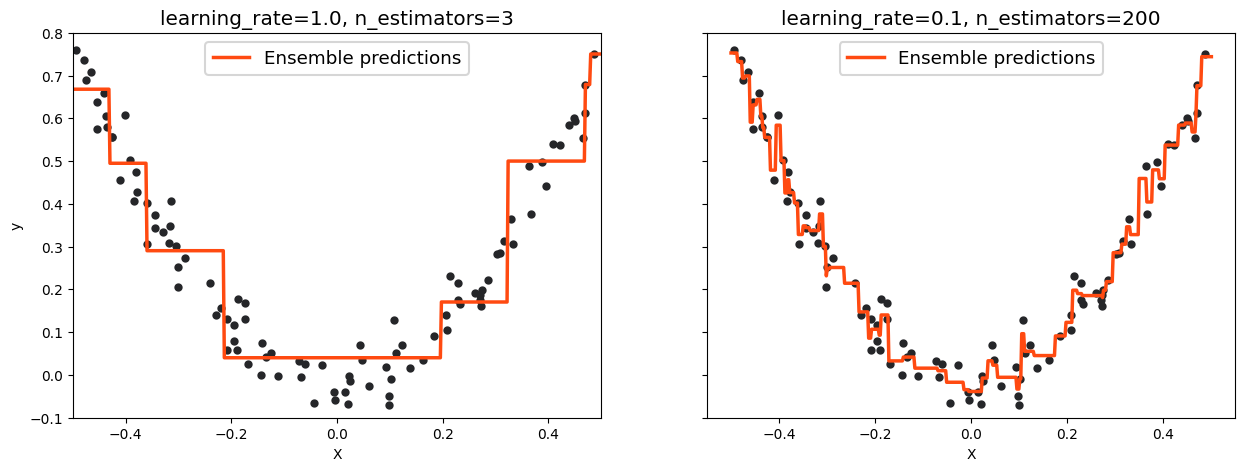

In [10]:
plot_ensemble(X, y, [gbrt_3, gbrt_200])  

### Early stopping

How many models do we add?

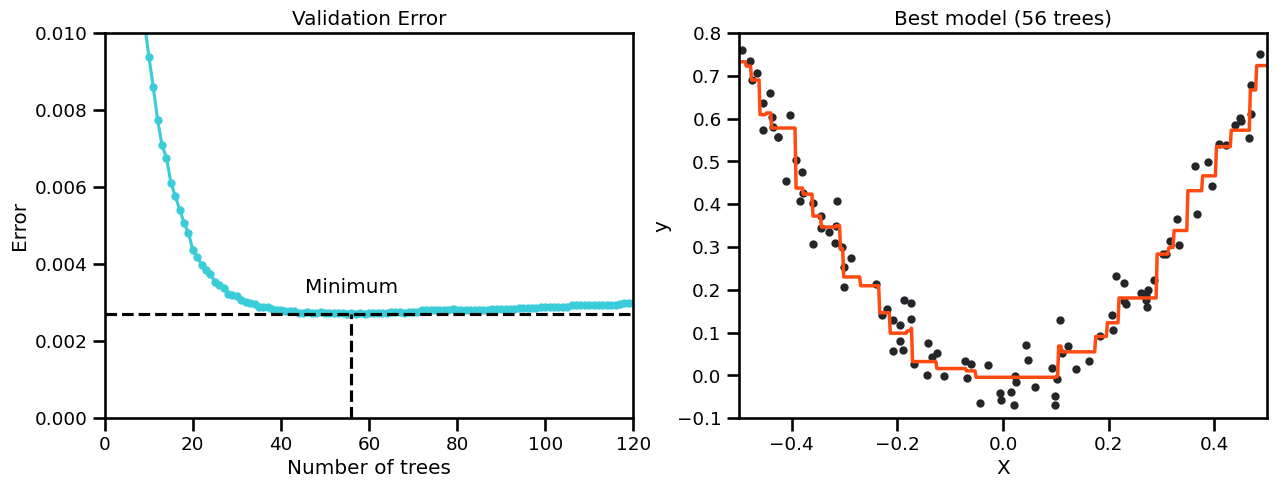

In [11]:
plot_early_stopping(X, y, gbrt_best)

### Examples for boosting algorithms

* AdaBoost
* LogitBoost
* Gradient Boost
* Stochastic Gradient Boost
* XGBoost (eXtreme Gradient Boost)

### Boosting optimization

$$ min\sum{L(y_i, f(x_i))}$$

<br>

<center>
    <img src="../images/ensemble_methods/img_p46_2.png" width=1000>
</center>

Notes: L(y, ŷ) is some loss function.. and there are some common choices for L

### Boosting methods Adaboost



<div class="group">
    <div class="text_70">

* loss function is exponential
* it’s putting lots of weight on misclassified examples
* after many iterations it can “carve out” a complex decision boundary
* slow to overfit
* sensitive to outliers
* probability estimates from f(x) cannot be recovered
    </div>
    <div class="images_30">
        <img src="../images/ensemble_methods/img_p47_1.png">
    </div>
</div>


Notes: Visualisations of the different loss functions and how they differently penalise the errors

### Boosting methods Logitboost

<div class="group">
    <div class="text_70">

* loss function is logloss
* punishes mistakes linearly
* one can extract probabilities from f(x)
    </div>
    <div class="images_30">
        <img src="../images/ensemble_methods/img_p47_1.png">
    </div>
</div>


Notes: Visualisations of the different loss functions and how they differently penalise the errors

### Boosting methods Gradient boosting
* sequentially adding predictors
* based on the errors of the preceding model
* instead of minimizing the loss function at each stage to get the parameter update for f, we get $g_m$ the gradient for the loss of $f_{m-1}$

$f_m=f_{m-1}- \rho_m g_m$ , where $\rho$ is the step length chosen by minimising the error


<div class="alert alert-block alert-info">
<b>Note:</b> 
    
Target outcomes for each case are set based on the gradient of the error with respect to the prediction.

</div>


Notes: How is aggregation done here?

### Stochastic Gradient Boosting

* use a random subset of instances
* higher bias but lower variance
* speeds up training

Notes: Parameter f: constant fraction of the training set randomly sampled. Optimal for small to medium-sized datasets: 0.5 <= f <= 0.8

### XGboost - Extreme Gradient Boosting

* optimized implementation
* scalable
* automatic implementation of early stopping and many more

Chen, T. and Guestrin, C. (2016): “XGBoost: A Scalable Tree Boosting System”

<div class="slide-chapter-split">
    <div class="title-chapter">BREAK</div>
    <div class="image-container">
        <img src="../images/general/break.png">
    </div>
</div>

## IV. Stacking


<div class="slide-chapter">

## IV. Stacking
    
</div>


### Use a model to aggregate

<div class="group">
    <div class="text_70">

* **train** weak learners in **parallel**
* combine by choosing the best for each observation
* this will obviously overfit
* using cross-validation to avoid overfitting
        
Applications: netflix competition winners in 2009 


Blending (holdout)  → Stacking (CV)

In [12]:
chart("""
flowchart TD
    A(New instance) --> B(Model 1 
    fa:fa-cogs) --> F(( 3.1 )) --> J{blending
    } --> K((3.0))
    A --> C(Model 2
    fa:fa-cogs) --> G(( 2.7 )) --> J
    A --> D(Model 3 
    fa:fa-cogs) --> H(( 2.9 )) --> J

    subgraph "Predict"
        B
        C
        D
    end
""")

Notes: Der Trick funktioniert über Datenset-Splitting. Der Blender muss auf anderen Daten trainiert werden als die Predictors. Features sind die Outputs der Predictors und Labels die Original label. Level 0 Model (Basemodel) Level 1 model (Meta-Mode) -> trained on holdout data Blending: Stacking-type ensemble where the meta-model is trained on predictions made on a holdout dataset. Stacking: Stacking-type ensemble where the meta-model is trained on out-of-fold predictions made during k-fold cross-validation.

## V. Classifier calibration


<div class="slide-chapter">

## V. Classifier calibration

</div>

### Calibrated probabilities

<div class="group">
    <div class="text">
        
Fitting a regressor (called a calibrator) that maps the output of the classifier (decision_function or predict_proba) to a calibrated probability in [0, 1]

[sklearn - calibrated probabilities](https://scikit-learn.org/stable/modules/calibration.html)
    </div>
    <div class="images">
        <img src="../images/ensemble_methods/img_p56_3.png">
    </div>
</div>

Notes: Calibrating a classifier consists of fitting a regressor (called a calibrator) that maps the output of the classifier (as given by decision_function or predict_proba) to a calibrated probability in [0, 1]. Denoting the output of the classifier for a given sample by fi , the calibrator tries to predict p(yi=1|fi) . The samples that are used to fit the calibrator should not be the same samples used to fit the classifier, as this would introduce bias. This is because performance of the classifier on its training data would be better than for novel data. Using the classifier output of training data to fit the calibrator would thus result in a biased calibrator that maps to probabilities closer to 0 and 1 than it should.

## Interpretability

<div class="slide-chapter">

## Interpretability
    
</div>

### Interpreting black box models
* Linear models are popular due to interpretability, but poor performance
* Conclusions on the importance of a variable should be based on models with good accuracy
* Some of the approaches for measuring the effect of variables:
    * partial dependence plot
    * feature importance
    * shapley values


Notes: Each split in a decision tree is guided by a variable. The Gini Gain then defines the impact of this variable in the model.

### Partial dependence plots - PROS

<div class="group">
    <div class="text">
        
* Intuitive: the partial dependence function at a particular feature value represents the average prediction if we force all data points to assume that value
* causal interpretation (for the model)

    </div>
    <div class="images">
        <img src="../images/ensemble_methods/img_p59_1.png">
    </div>
</div>

### Partial dependence plots - CONS

<div class="group">
    <div class="text">

* maximum 2 features per plot
* assumption of independence between features
* some pd plots do not show the feature distribution

    </div>
    <div class="images">
        <img src="../images/ensemble_methods/img_p59_1.png">
    </div>
</div>

Notes: Each split in a decision tree is guided by a variable. The Gini Gain then defines the impact of this variable in the model.

### Permutation feature importance - PROS

<div class="group">
    <div class="text">

* nice interpretation: the loss if the feature is removed
* it takes into account the interaction with other features
* does not require retraining the model

    </div>
    <div class="images">
        <img src="../images/ensemble_methods/img_p60_1.png">
    </div>
</div>

### Permutation feature importance - CONS

<div class="group">
    <div class="text">

* unclear if to use train or test data
* linked to the error of model
* need access to true outcome of model
* doesn’t deal well with correlated features

    </div>
    <div class="images">
        <img src="../images/ensemble_methods/img_p60_1.png">
    </div>
</div>

Notes: Each split in a decision tree is guided by a variable. The Gini Gain then defines the impact of this variable in the model.

## References

* Machine learning a probabilistic perspective - Kevin p. Murphy
* https://arxiv.org/pdf/1106.0257.pdf
* https://arxiv.org/pdf/1307.6522.pdf
* [Voting classifier blogpost](https://medium.com/@sanchitamangale12/voting-classifier-1be10db6d7a5)
* [Difference between extra trees and random forest](https://quantdare.com/what-is-the-difference-between-extra-trees-and-random-fo)
* [Model design and selection with sklearn](https://towardsdatascience.com/model-design-and-selection-with-scikit-learn-18a29041d02a)
* [Interpretable ML book](https://christophm.github.io/interpretable-ml-book)
* [Partial dependency plots](https://www.kaggle.com/dansbecker/partial-dependence-plots)